# Navigation in Habitat

> **Note**: This tutorial is borrowed from [ECCV 2020 Tutorials on Habitat](https://aihabitat.org/tutorial/2020/). The official notebook similar to this one can be found [here](https://colab.research.google.com/github/facebookresearch/habitat-sim/blob/main/examples/tutorials/colabs/ECCV_2020_Navigation.ipynb)

This is a self contained notebook, with setup instructions and basic things about the Facebook Habitat simulator. 
The aim is to cover installation and basics of navigation in Habitat simulator.

It is assumed that a headless server is being used.


## Installation and setup

Installing and setting up Habitat (headless with bullet physics)


### Conda

Follow instructions on *GitHub* [here](https://github.com/facebookresearch/habitat-sim#installation). We use `conda`. Run the following


```bash
    # We require python>=3.7 and cmake>=3.10
    conda create -n habitat python=3.7 cmake=3.14.0
    conda activate habitat
    # If installing for headless server
    conda install habitat-sim withbullet headless -c conda-forge -c aihabitat
    # If installing for system with display attached
    conda install habitat-sim withbullet -c conda-forge -c aihabitat
```

You could also use the one-shot setup script (risky!) they have on [GitHub](https://github.com/facebookresearch/habitat-sim/blob/main/examples/colab_utils/colab_install.sh)

The C++ [tests](https://github.com/facebookresearch/habitat-sim#testing) (using `habitat-viewer`) can be run separately. I recommend running them on a server with display attached.


## Before Starting

Some terminology

- An **embodied agent** is an intelligent agent that can perceive and interact with the environment to accomplish any task
- Usually, a **sensor** perceives the **scene**. A **SceneGraph** stores all the scene objects into regions and objects. A **simulator** runs in the back-end, it can update the state of the world (agent + scene graph) and provide observations for sensors.


Before getting started, set up the datasets

```bash
    # Download all the data somewhere
    mkdir -p /scratch/$USER/habitat-data
    cd /scratch/$USER/habitat-data
    python -m habitat_sim.utils.datasets_download --uids ci_test_assets --replace --data-path /scratch/$USER/habitat-data
```

In [1]:
# Place where the dataset was downloaded
data_path = "/scratch/avneesh.mishra/habitat-data"

# Place where all outputs should be stored
out_dir = "/scratch/avneesh.mishra/habitat-out/navigation-tutorial"

## Let's Get Started

In [2]:
# Import everything
import habitat_sim
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os

Some checks 

In [3]:
# Output folder
if os.path.isdir(out_dir):
    print(f"Output directory {out_dir} already exists, overwriting files!")
else:
    os.makedirs(out_dir)
    print(f"Output directory {out_dir} created")
# Data path(s)
assert os.path.isdir(data_path), f"Data not found in {data_path}"

Output directory /scratch/avneesh.mishra/habitat-out/navigation-tutorial already exists, overwriting files!


Utility function for showing color images, semantic masks, depth maps as a row

In [4]:
# Show the data sample
def show_data_sample(img_obj, semantic_obj=None, depth_obj=None):
    """
        Visualize the data passed (only one sample). `None` items are ignored.
        - img_obj: (H, W, 4): RGBA image
        - semantic_obj: (H, W): Semantic segmentation map (instance or class)
        - depth_obj: (H, W): Depth map of corresponding pixels
    """
    # RGB Image
    rgb_img = Image.fromarray(img_obj, mode="RGBA")
    data = [rgb_img]
    titles = ["RGB"]
    # Semantic object
    from habitat_sim.utils.common import d3_40_colors_rgb
    if semantic_obj is not None:
        sem_img = Image.new(mode="P", # Color palette image
            size=(semantic_obj.shape[1], semantic_obj.shape[0]))
        sem_img.putpalette(d3_40_colors_rgb.flatten())
        sem_img.putdata((semantic_obj.flatten() % 40).astype(np.uint8))
        sem_img = sem_img.convert(mode="RGBA")
        data.append(sem_img)
        titles.append("Semantic")
    # Depth object
    if depth_obj is not None:
        depth_img = Image.fromarray((depth_obj / 10 * 255).astype(np.uint8),
            mode="L")   # Greyscale image
        data.append(depth_img)
        titles.append("Depth")
    # Show the image(s)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(1, len(titles))
    for i, img in enumerate(data):
        ax = fig.add_subplot(gs[0, i])
        ax.set_axis_off()
        ax.set_title(titles[i])
        ax.imshow(img)
    plt.show(block=False)

### Visualize a scene

Read the scene

3D models are stored in the [GLB file format](https://visao.ca/what-is-glb-file/)

In [5]:
test_scene = "/scratch/avneesh.mishra/habitat-data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb"

assert os.path.isfile(test_scene)

Simulator settings (backend and agent)

- [habitat_sim.simulator.Configuration](https://aihabitat.org/docs/habitat-sim/habitat_sim.simulator.Configuration.html): Takes the configurations of the simulation environment and various agents.
    - [habitat_sim.sim.SimulatorConfiguration](https://aihabitat.org/docs/habitat-sim/habitat_sim.sim.SimulatorConfiguration.html): Simulator configuration (scene and environment)
    - [habitat_sim.agent.AgentConfiguration](https://aihabitat.org/docs/habitat-sim/habitat_sim.agent.AgentConfiguration.html): Agent configuration . We'll only attach sensors, but you can also define agent as cylinder and define action spaces.
        - [habitat_sim.sensor.SensorSpec](https://aihabitat.org/docs/habitat-sim/habitat_sim.sensor.SensorSpec.html): Sensor specifications

In [6]:
sim_settings = {
    "backend": {
        "scene": test_scene,
    },
    "agent": {
        "number": 0,
        "sensor_height": 1.5,
        # Spatial resolution of observations
        "sr_width": 256,
        "sr_height": 256
    }
}

In [7]:
# Make simple configurations
def make_habitat_cfg(settings):
    sim_cfg = habitat_sim.sim.SimulatorConfiguration()
    # Backend configurations
    sim_cfg.scene_id = settings["backend"]["scene"]
    # Agent(s) configurations
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    # Sensor(s) for the embodied agent
    rgb_sensor_spec = habitat_sim.sensor.CameraSensorSpec()
    rgb_sensor_spec.uuid = "color_sensor"
    rgb_sensor_spec.sensor_type = habitat_sim.sensor.SensorType.COLOR
    rgb_sensor_spec.resolution = [  # Resolution of sensor
        settings["agent"]["sr_height"], settings["agent"]["sr_width"]]
    rgb_sensor_spec.position = [0.0, settings["agent"]["sensor_height"], 0.0]
    agent_cfg.sensor_specifications = [rgb_sensor_spec]
    return habitat_sim.simulator.Configuration(sim_cfg, [agent_cfg])

Create a simulator from configurations

- [habitat_sim.simulator.Simulator](https://aihabitat.org/docs/habitat-sim/habitat_sim.simulator.Simulator.html): Main simulator class that takes configurations and performs all actions

In [8]:
cfg = make_habitat_cfg(sim_settings)
# Close an existing simulation instance (if already there)
try:
    sim.close()
    print("===== Existing simulator has been closed =====")
except NameError:
    pass
sim = habitat_sim.simulator.Simulator(cfg)

[23:00:05:456264]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default| This file does not exist.
[23:00:05:456400]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[23:00:05:456462]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[23:00:05:456513]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[23:00:05:456557]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneWireframe:coneWireframe_s

#### Basic Navigate and Sight

Simple task of moving around in an environment and retrieving data from the sensors

Initialize the agent with state

In [9]:
# Initialize agent
agent = sim.initialize_agent(sim_settings["agent"]["number"])
# Set the agent state in the environment
agent_state = habitat_sim.agent.AgentState()
agent_state.position = np.array([-0.6, 0.0, 0.0])
agent.set_state(agent_state)
# Get agent state in environment
_agent_state = agent.get_state()
print(f"Agent position: {_agent_state.position}, "\
    f"orientation: {_agent_state.rotation}")

Agent position: [-0.6  0.   0. ], orientation: quaternion(1, 0, 0, 0)


In [10]:
ac_sp = list(cfg.agents[sim_settings["agent"]["number"]].action_space.keys())
print(f"Actions: {ac_sp}")

# Move and see
def navigateAndSee(action="", disp=True, save_data=None):
    """
        Apply a particular action and perceive the environment.
        - action: str               An action
        - disp: bool                Display the results (data)
    """
    if action in ac_sp:
        obs = sim.step(action)
        if disp:
            print(f"Action: {action}")
            show_data_sample(obs["color_sensor"])
        return obs

Actions: ['move_forward', 'turn_left', 'turn_right']


1) Action: move_forward


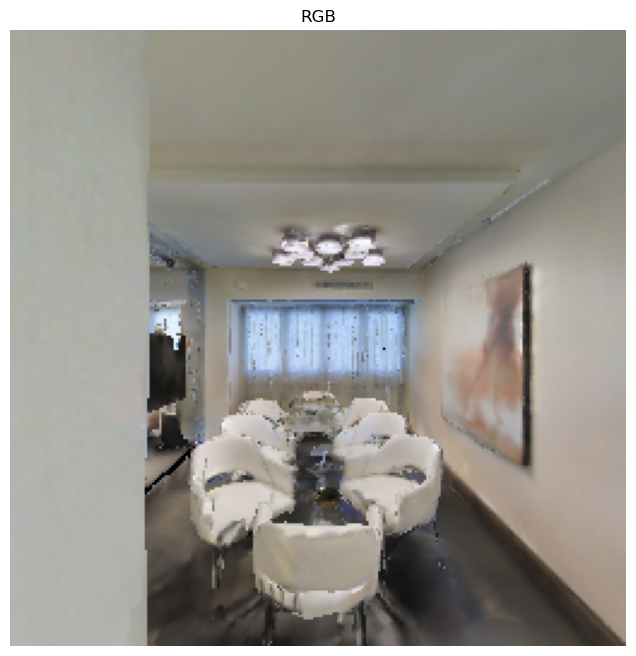

	Position: [-0.6       0.072447 -0.25    ] 
	Orientation: quaternion(1, 0, 0, 0) 
	Collided: False
2) Action: move_forward


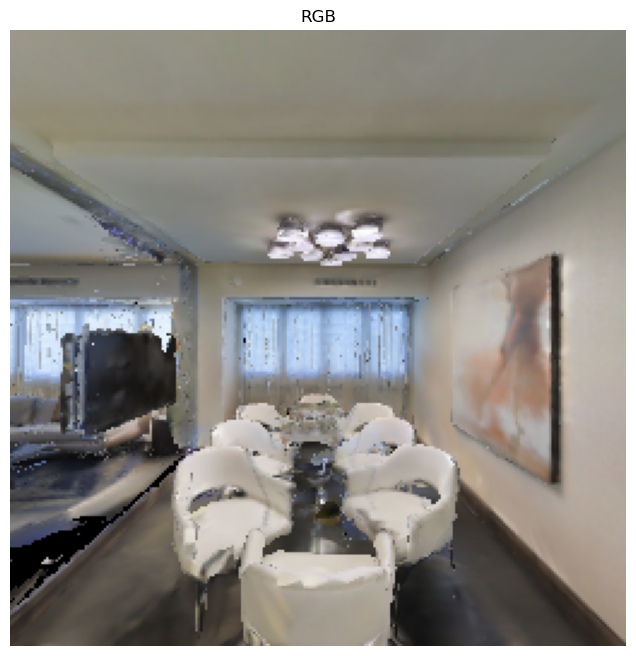

	Position: [-0.6       0.072447 -0.5     ] 
	Orientation: quaternion(1, 0, 0, 0) 
	Collided: False
3) Action: turn_right


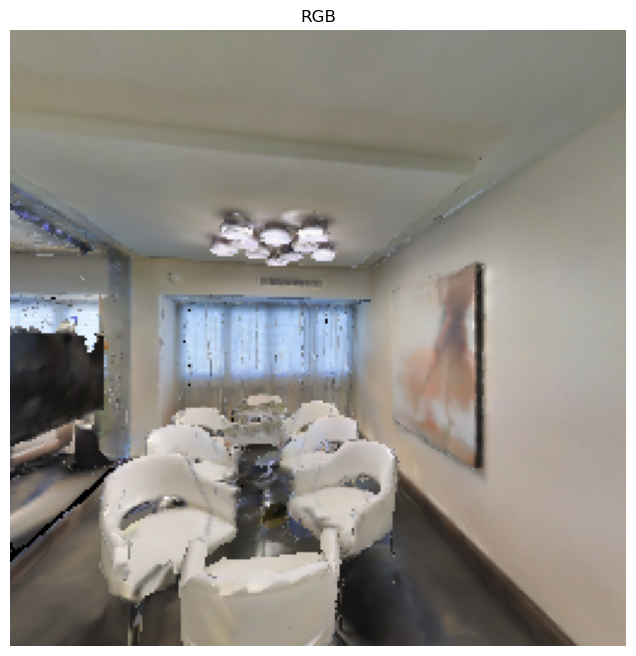

	Position: [-0.6       0.072447 -0.5     ] 
	Orientation: quaternion(0.99619472026825, 0, -0.0871557369828224, 0) 
	Collided: False
4) Action: move_forward


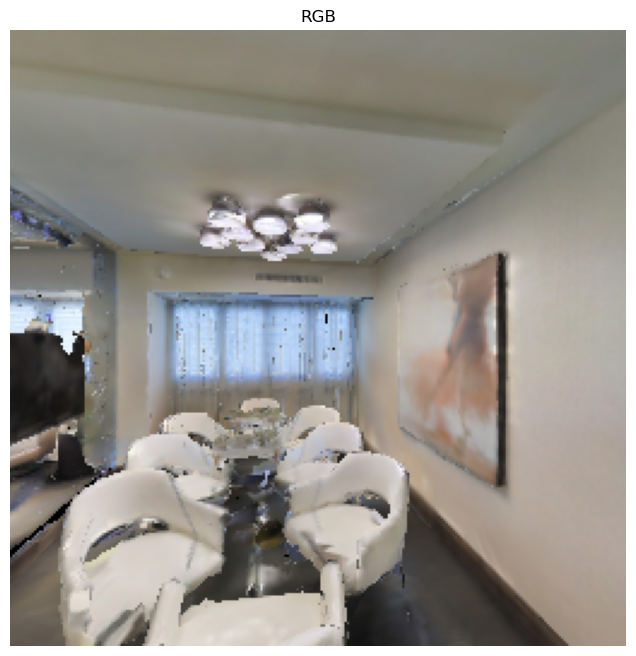

	Position: [-0.556588    0.072447   -0.74620193] 
	Orientation: quaternion(0.99619472026825, 0, -0.0871557369828224, 0) 
	Collided: False
5) Action: turn_left


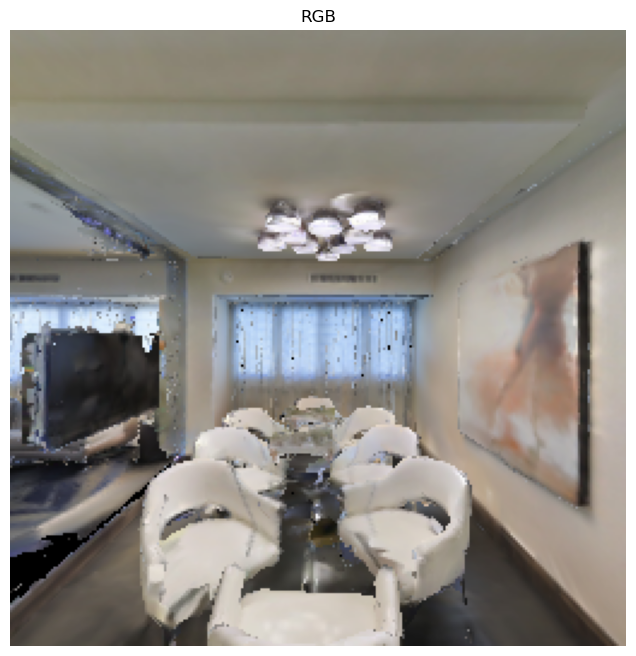

	Position: [-0.556588    0.072447   -0.74620193] 
	Orientation: quaternion(1, 0, 0, 0) 
	Collided: False


In [11]:
# Action sequence
actions = ["move_forward", "move_forward", "turn_right", 
    "move_forward", "turn_left"]
for i, action in enumerate(actions):
    print(f"{i+1}) ", end="")
    obs = navigateAndSee(action)
    curr_state = agent.get_state()
    print(f"\tPosition: {curr_state.position} \n\t"\
          f"Orientation: {curr_state.rotation} \n\t"\
          f"Collided: {obs['collided']}")

In [12]:
agent_state = agent.get_state()
print(f"Agent at (pos, quat): {agent_state.position}, {agent_state.rotation}")
if obs["collided"]:
    print("The agent has collided with an obstacle in the environment")
else:
    print("The agent has not collided to anything in the environment")

Agent at (pos, quat): [-0.556588    0.072447   -0.74620193], quaternion(1, 0, 0, 0)
The agent has not collided to anything in the environment


In [13]:
img = Image.fromarray(obs["color_sensor"])
img.save(f"{out_dir}/first_rgb.png")
print(f"Saving current view as PNG")

Saving current view as PNG


In [14]:
# Delete everything for the upcoming section
sim.close()

[23:00:13:492324]:[Physics] PhysicsManager.cpp(50)::~PhysicsManager : Deconstructing PhysicsManager
[23:00:13:492478]:[Scene] SceneManager.h(25)::~SceneManager : Deconstructing SceneManager
[23:00:13:492497]:[Scene] SceneGraph.h(25)::~SceneGraph : Deconstructing SceneGraph
[23:00:13:492735]:[Sensor] Sensor.cpp(69)::~Sensor : Deconstructing Sensor
[23:00:13:492777]:[Scene] SceneGraph.h(25)::~SceneGraph : Deconstructing SceneGraph
[23:00:13:493224]:[Scene] SemanticScene.h(47)::~SemanticScene : Deconstructing SemanticScene
[23:00:13:501386]:[Gfx] Renderer.cpp(72)::~Impl : Deconstructing Renderer
[23:00:13:501455]:[Gfx] WindowlessContext.h(17)::~WindowlessContext : Deconstructing WindowlessContext


---


## Beyond Getting Started

We'll do the following over the above
- An agent with RGB, Depth, and Semantic sensors in a scene
- Exploring all entities in a semantic scene (to see what it contains)


Exploring the scene information. This is a JSON file containing more information about the scene.

There are more files in the folder where the `test_scene` is. The method to find these files is present in this JSON file.

- [JSON Files to configure Attributes](https://aihabitat.org/docs/habitat-sim/attributesJSON.html) and [SceneDatasetAttributes](https://aihabitat.org/docs/habitat-sim/attributesJSON.html#scenedatasetattributes)
- [Stage Mesh Handles and Types](https://aihabitat.org/docs/habitat-sim/attributesJSON.html#stage-mesh-handles-and-types): For `["stages"]["default_attributes"]["*_asset"]` and `["stages"]["default_attributes"]["semantic_descriptor_filename"]`. They define properties like
    - `nav_asset`: Contains the **NavMesh**. This describes the places in the scene where the agent can navigate (free places)
    - `semantic_asset`: Stage's semantic mesh
    - `semantic_descriptor_filename`: Semantic mapping for the stage

In [15]:
scene_info = "/scratch/avneesh.mishra/habitat-data/scene_datasets/mp3d_example/mp3d.scene_dataset_config.json"

assert os.path.isfile(scene_info)

In [16]:
print(f"Contents of config: {scene_info}")
os.system(f"cat {scene_info}")

Contents of config: /scratch/avneesh.mishra/habitat-data/scene_datasets/mp3d_example/mp3d.scene_dataset_config.json
{
  "stages": {
    "paths": {
      ".glb": [
        "*/*.glb"
      ]
    },
    "default_attributes": {
      "shader_type": "flat",
      "nav_asset": "%%CONFIG_NAME_AS_ASSET_FILENAME%%.navmesh",
      "semantic_asset": "%%CONFIG_NAME_AS_ASSET_FILENAME%%_semantic.ply",
      "semantic_descriptor_filename": "%%CONFIG_NAME_AS_ASSET_FILENAME%%.house",
      "up": [
        0,
        0,
        1
      ],
      "front": [
        0,
        1,
        0
      ],
      "semantic_up": [
        0,
        1,
        0
      ],
      "semantic_front": [
        0,
        0,
        -1
      ],
      "origin": [
        0,
        0,
        0
      ]
    }
  },
  "objects": {},
  "light_setups": {},
  "scene_instances": {
    "default_attributes": {
      "default_lighting": "no_lights"
    }
  }
}

0

In [17]:
# Re-defining the single agent simulator settings
sim_settings = {
    "scene": test_scene,
    "info": scene_info,
    "physics": False,
    "agent": {
        "id": 0,
        "sensor_height": 1.5,
        "s_height": 256,
        "s_width": 256,
    }
}

In [18]:
# Make simple configurations for agent (more sophisticated)
def make_habitat_cfg(settings):
    sim_cfg = habitat_sim.sim.SimulatorConfiguration()
    # Backend scene configurations
    sim_cfg.scene_id = settings["scene"]
    sim_cfg.scene_dataset_config_file = settings["info"]
    sim_cfg.enable_physics = settings["physics"]
    
    # Add sensors
    sensor_specs = []
    sens_res = [settings["agent"]["s_height"], settings["agent"]["s_width"]]
    # Camera
    cam_sensor_specs = habitat_sim.sensor.CameraSensorSpec()
    cam_sensor_specs.uuid = "cam"
    cam_sensor_specs.sensor_type = habitat_sim.sensor.SensorType.COLOR
    cam_sensor_specs.resolution = sens_res
    cam_sensor_specs.position = [0.0, settings["agent"]["sensor_height"], 0.0]
    cam_sensor_specs.sensor_subtype = habitat_sim.sensor.SensorSubType.PINHOLE
    sensor_specs.append(cam_sensor_specs)
    # Depth sensor
    depth_sensor_specs = habitat_sim.sensor.CameraSensorSpec()
    depth_sensor_specs.uuid = "depth"
    depth_sensor_specs.sensor_type = habitat_sim.sensor.SensorType.DEPTH
    depth_sensor_specs.resolution = sens_res
    depth_sensor_specs.position = [0.0, settings["agent"]["sensor_height"], 0.0]
    depth_sensor_specs.sensor_subtype = habitat_sim.sensor.SensorSubType.PINHOLE
    sensor_specs.append(depth_sensor_specs)
    # Semantic sensor
    sem_sensor_specs = habitat_sim.sensor.CameraSensorSpec()
    sem_sensor_specs.uuid = "sem"
    sem_sensor_specs.sensor_type = habitat_sim.sensor.SensorType.SEMANTIC
    sem_sensor_specs.resolution = sens_res
    sem_sensor_specs.position = [0.0, settings["agent"]["sensor_height"], 0.0]
    sem_sensor_specs.sensor_subtype = habitat_sim.sensor.SensorSubType.PINHOLE
    sensor_specs.append(sem_sensor_specs)
    
    # Configure agent and actions
    agent_cfg = habitat_sim.agent.AgentConfiguration()
    agent_cfg.sensor_specifications = sensor_specs
    agent_cfg.action_space = {
        "fwd": habitat_sim.agent.ActionSpec("move_forward", 
            habitat_sim.agent.ActuationSpec(amount=0.25)),
        "left": habitat_sim.agent.ActionSpec("turn_left", 
            habitat_sim.agent.ActuationSpec(amount=30)),
        "right": habitat_sim.agent.ActionSpec("turn_right", 
            habitat_sim.agent.ActuationSpec(amount=30)),
    }

    # Return all settings
    return habitat_sim.simulator.Configuration(sim_cfg, [agent_cfg])

Create main simulator

In [19]:
cfg = make_habitat_cfg(sim_settings)
# Close an existing simulation instance (if already there)
try:
    sim.close()
    print("===== Existing simulator has been closed =====")
except NameError:
    pass
sim = habitat_sim.simulator.Simulator(cfg)

===== Existing simulator has been closed =====
[23:00:13:996836]:[Metadata] AttributesManagerBase.h(380)::createFromJsonOrDefaultInternal : <Dataset>: Proposing JSON name : default.scene_dataset_config.json from original name : default

[23:00:13:998617]:[Metadata] SceneDatasetAttributesManager.cpp(308)::readDatasetJSONCell : "stages.default_attributes" set in Attributes Manager from JSON.
[23:00:13:998709]:[Metadata] AttributesManagerBase.h(352)::buildAttrSrcPathsFromJSONAndLoad : Glob path result for /scratch/avneesh.mishra/habitat-data/scene_datasets/mp3d_example/*/*.glb : /scratch/avneesh.mishra/habitat-data/scene_datasets/mp3d_example/17DRP5sb8fy/17DRP5sb8fy.glb
[23:00:13:998922]:[Metadata] SceneInstanceAttributesManager.cpp(65)::setValsFromJSONDoc : No Stage specified for scene default_attributes , or specification error.
[23:00:13:998933]:[Metadata] SceneInstanceAttributesManager.cpp(105)::setValsFromJSONDoc : No Articulated Objects specified for scene default_attributes , or specification error.
[23:00:13:998945]:[Metadata] SceneInstanceAttributesManager.cpp(125)::setValsFromJSONDoc : No navmesh_instance specified for scene default_attributes .
[23:00:13:998955]:[Metadata] SceneInstanceAttributesManager.cpp(13

| This file does not exist.
[23:00:13:996957]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DSolid:capsule3DSolid_hemiRings_4_cylRings_1_segments_12_halfLen_0.75_useTexCoords_false_useTangents_false) created and registered.
[23:00:13:997029]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (capsule3DWireframe:capsule3DWireframe_hemiRings_8_cylRings_1_segments_16_halfLen_1) created and registered.
[23:00:13:997080]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneSolid:coneSolid_segments_12_halfLen_1.25_rings_1_useTexCoords_false_useTangents_false_capEnd_true) created and registered.
[23:00:13:997109]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (coneWireframe:coneWireframe_segments_32_halfLen_1.25) created and registered.
[23:00:13:997141]:[Metadata] AssetAttributesManager.cpp(121)::createObject : Asset attributes (cubeSolid:cubeSolid) created and registered.

### Semantic scene configuration

A graph stores all the 

- [sim.semantic_scene](https://aihabitat.org/docs/habitat-sim/habitat_sim.simulator.Simulator.html#semantic_scene): A [SemanticScene](https://aihabitat.org/docs/habitat-sim/habitat_sim.scene.SemanticScene.html) class object

In [20]:
scene_data = sim.semantic_scene
print("Axis aligned bounding-box\n\t" \
     f"Center: {scene_data.aabb.center}\n\t" \
     f"Size: {scene_data.aabb.sizes}")

Axis aligned bounding-box
	Center: [-2.7928104  1.3372791 -1.5051247]
	Size: [17.57338    2.9023619  8.8595495]


The scene is decomposed into `levels -> regions -> objects`

In [21]:
count = 0
for level in scene_data.levels:
    print(f"Level: {level.id}\n\t" \
          f"Center: {level.aabb.center}\n\t" \
          f"Size: {level.aabb.sizes}\n\t" \
          f"Regions: {len(level.regions)}")
    for region in level.regions:
        print(f"\tRegion: {region.id} "\
              f"(category: {region.category.name()})\n\t" \
              f"Center: {region.aabb.center}, size{region.aabb.sizes}")
        print(f"\tObjects: {len(region.objects)}")
        for object in region.objects:
            print(f"\t\tObject: {object.id}, "\
                  f"category: {object.category.name()}")
            count += 1
print(f"Total {count} objects")

Level: 0
	Center: [-3.1573648  1.33728   -1.5051247]
	Size: [16.69967    2.90236    8.8595495]
	Regions: 10
	Region: 0_0 (category: bedroom)
	Center: [-8.821845   1.2594094 -2.691538 ], size[4.163309  2.5356622 4.2073426]
	Objects: 22
		Object: 0_0_0, category: wall
		Object: 0_0_1, category: ceiling
		Object: 0_0_2, category: misc
		Object: 0_0_3, category: curtain
		Object: 0_0_4, category: void
		Object: 0_0_5, category: bed
		Object: 0_0_6, category: void
		Object: 0_0_7, category: tv_monitor
		Object: 0_0_9, category: chest_of_drawers
		Object: 0_0_10, category: cushion
		Object: 0_0_11, category: chest_of_drawers
		Object: 0_0_12, category: floor
		Object: 0_0_13, category: misc
		Object: 0_0_14, category: lighting
		Object: 0_0_15, category: bed
		Object: 0_0_16, category: cushion
		Object: 0_0_17, category: void
		Object: 0_0_18, category: cushion
		Object: 0_0_19, category: table
		Object: 0_0_20, category: lighting
		Object: 0_0_21, category: cushion
		Object: 0_0_22, categor

Initialize agent

In [22]:
agent = sim.initialize_agent(sim_settings["agent"]["id"])
# Initialize agent at a position
start_agent_state = habitat_sim.agent.AgentState()
start_agent_state.position = np.array([-0.6, 0, 0])
agent.set_state(start_agent_state)
# Get agent state
agent_state = agent.get_state()
print(f"Agent: Position: {agent_state.position}, Rot: {agent_state.rotation}")

Agent: Position: [-0.6  0.   0. ], Rot: quaternion(1, 0, 0, 0)
[23:00:18:917178]:[Sim] Simulator.cpp(66)::~Simulator : Deconstructing Simulator


Perform actions (using our new keys)

0) Action fwd: move_forward


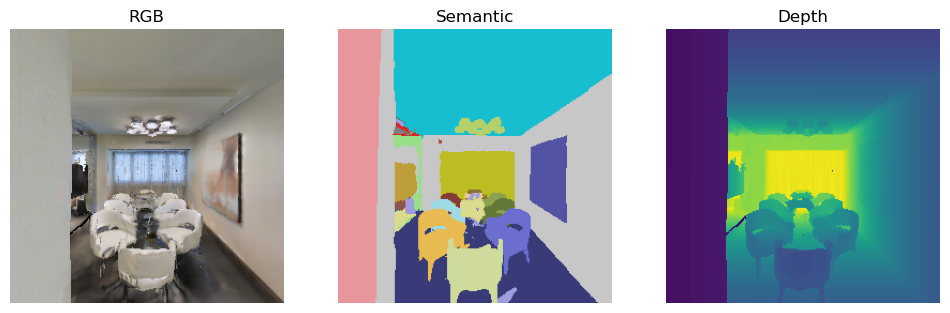

	Position: [-0.6       0.072447 -0.25    ], Rot: quaternion(1, 0, 0, 0)
	Collided: False
1) Action left: turn_left


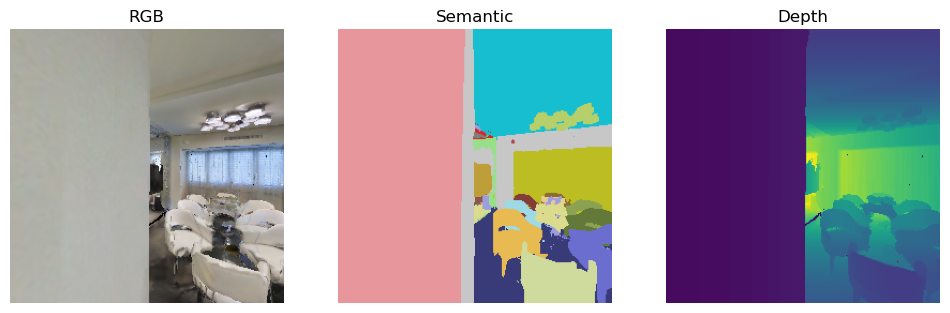

	Position: [-0.6       0.072447 -0.25    ], Rot: quaternion(0.965925872325897, 0, 0.258819073438644, 0)
	Collided: False
2) Action fwd: move_forward


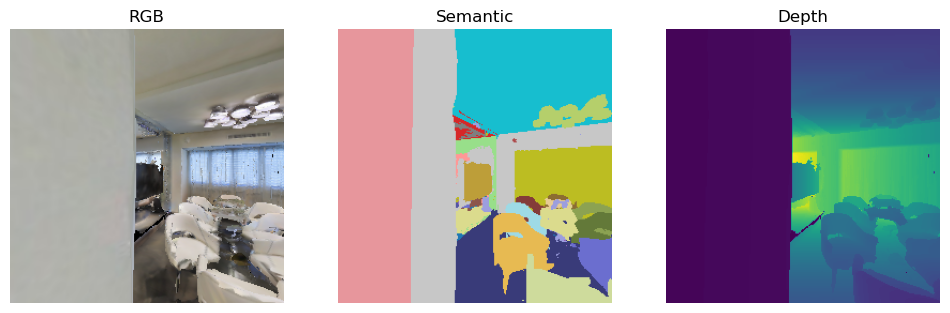

	Position: [-0.6934395   0.072447   -0.46650633], Rot: quaternion(0.965925872325897, 0, 0.258819073438644, 0)
	Collided: True
3) Action right: turn_right


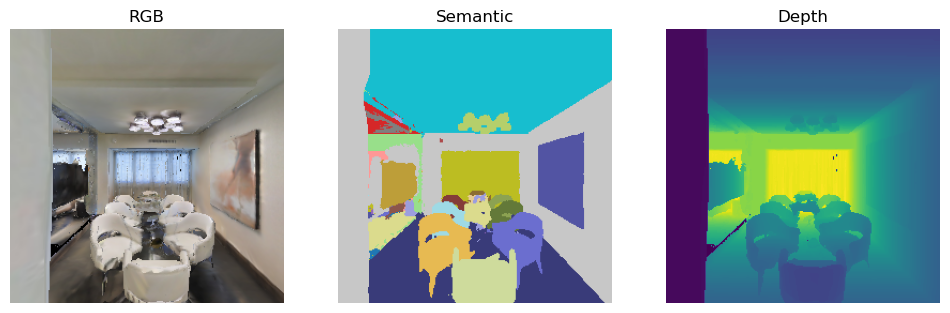

	Position: [-0.6934395   0.072447   -0.46650633], Rot: quaternion(1, 0, 2.98023223876953e-08, 0)
	Collided: False


In [23]:
actions = ["fwd", "left", "fwd", "right"]
for i, act in enumerate(actions):
    print(f"{i}) Action {act}: {agent.agent_config.action_space[act].name}")
    # Navigate and see the environment
    obs = sim.step(act)
    show_data_sample(obs["cam"], obs["sem"], obs["depth"])
    # Get agent state
    agent_state = agent.get_state()
    print(f"\tPosition: {agent_state.position}, Rot: {agent_state.rotation}")
    print(f"\tCollided: {obs['collided']}")


In [24]:
# Delete everything
sim.close()

[23:00:20:154783]:[Physics] PhysicsManager.cpp(50)::~PhysicsManager : Deconstructing PhysicsManager
[23:00:20:154882]:[Scene] SceneManager.h(25)::~SceneManager : Deconstructing SceneManager
[23:00:20:154903]:[Scene] SceneGraph.h(25)::~SceneGraph : Deconstructing SceneGraph
[23:00:20:155534]:[Sensor] Sensor.cpp(69)::~Sensor : Deconstructing Sensor
[23:00:20:155660]:[Sensor] Sensor.cpp(69)::~Sensor : Deconstructing Sensor
[23:00:20:155706]:[Sensor] Sensor.cpp(69)::~Sensor : Deconstructing Sensor
[23:00:20:155733]:[Scene] SceneGraph.h(25)::~SceneGraph : Deconstructing SceneGraph
[23:00:20:160160]:[Gfx] Renderer.cpp(72)::~Impl : Deconstructing Renderer
[23:00:20:160219]:[Gfx] WindowlessContext.h(17)::~WindowlessContext : Deconstructing WindowlessContext


---